In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

import requests
from lxml import etree as et

import pandas_datareader.data as web
import quandl

import pickle
from IPython.display import Image

import zipline
from zipline.api import order, record, symbol, order_target, set_commission, commission, set_benchmark
from zipline.algorithm import TradingAlgorithm

In [77]:
!python --version

Python 3.5.6 :: Anaconda, Inc.


In [78]:
quandl.ApiConfig.api_key = "BMQ11-wVhk-Rt78SQoi9"
api_key = "BMQ11-wVhk-Rt78SQoi9"

In [121]:
## Import 2Y, 10Y, 30Y T-Bill data from treasury.gov (as XML)

start_year = 2013
end_year = 2018

tbill_df = pd.DataFrame()

for year in range(start_year, end_year+1):
    url = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldYear&year={0}".format(year)
    xmlurl = "http://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20{0}".format(year)

    xmlcontent = requests.get(xmlurl).content # type: bytes
    xmlcontent = et.fromstring(xmlcontent) # type: lxml.etree_Element

#     tree = et.ElementTree(xmlcontent)
#     for i in xmlcontent.iter():
#         print(tree.getpath(i)) # Tree에서 각 element의 Path를 확인할 수 있다. 

    namespaces = xmlcontent.nsmap
    paths = ['.//d:NEW_DATE', './/d:BC_2YEAR', './/d:BC_10YEAR', './/d:BC_30YEAR']
    
    temp_df = pd.DataFrame()
    for i in paths:
        rates = xmlcontent.findall(path=i, namespaces=namespaces)
        temp_df[i[5:]] = [x.text for x in rates]
        
    tbill_df = tbill_df.append(temp_df, ignore_index=True)
        
tbill_df = tbill_df.rename(columns={'NEW_DATE':"Date"})
tbill_df.Date = pd.to_datetime(tbill_df.Date)
tbill_df = tbill_df.set_index('Date')
tbill_df = tbill_df.astype(float)

print(tbill_df.head())
print(tbill_df.tail())

            BC_2YEAR  BC_10YEAR  BC_30YEAR
Date                                      
2013-01-02      0.27       1.86       3.04
2013-01-03      0.27       1.92       3.12
2013-01-04      0.27       1.93       3.10
2013-01-07      0.27       1.92       3.10
2013-01-08      0.25       1.89       3.06
            BC_2YEAR  BC_10YEAR  BC_30YEAR
Date                                      
2018-11-28      2.81       3.06       3.34
2018-11-29      2.81       3.03       3.33
2018-11-30      2.80       3.01       3.30
2018-12-03      2.83       2.98       3.27
2018-12-04      2.80       2.91       3.16


In [122]:
dd = tbill_df.BC_30YEAR - tbill_df.BC_2YEAR

In [127]:
dd.mean()

2.0192924528301903

In [81]:
! zipline ingest -b quantopian-quandl

[2018-12-05 06:51:07.809595] INFO: zipline.data.bundles.quandl: Writing data to C:\Users\Jaepil/.zipline\data\quantopian-quandl\2018-12-05T06;50;49.551946.


In [80]:
## Download Fama French 5 Factor data from Kenneth R. French's Data Library
## http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

ff5_df = pd.read_csv('FF5_daily_20181031.csv', skiprows=3)
ff5_df = ff5_df.rename(columns={"Unnamed: 0": "Date"})
ff5_df.Date = pd.to_datetime(ff5_df.Date, format="%Y%m%d")
ff5_df = ff5_df.set_index('Date')
ff5_df = ff5_df[ff5_df.index.year >= start_year]

print(ff5_df.head())
print(ff5_df.tail())

            Mkt-RF   SMB   HML   RMW   CMA   RF
Date                                           
2013-01-02    2.62  0.12  0.35 -0.62 -0.04  0.0
2013-01-03   -0.14  0.14  0.05  0.17  0.22  0.0
2013-01-04    0.55  0.19  0.43 -0.38  0.27  0.0
2013-01-07   -0.31 -0.08 -0.36 -0.10 -0.12  0.0
2013-01-08   -0.27  0.03 -0.06 -0.16  0.09  0.0
            Mkt-RF   SMB   HML   RMW   CMA     RF
Date                                             
2018-10-25    1.93  0.33 -0.72 -0.16 -1.09  0.008
2018-10-26   -1.65  0.57  0.37 -0.37  0.52  0.008
2018-10-29   -0.76 -0.07  1.63 -0.04  0.99  0.008
2018-10-30    1.66  0.43  0.11  0.36  0.38  0.008
2018-10-31    1.21 -0.68 -0.69 -0.39 -1.00  0.008


In [83]:
capital = 10000

In [84]:
stocks = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL'] # FAANG

In [128]:
def initialize(context):
    set_commission(commission.PerDollar(cost=0.0015)) # 0.15% 
    
    context.i = 0
    context.sym = symbol('AAPL')
#     context.stocks = stocks
    context.hold = False # 초기에는 주식을 보유하지 않음. 

def handle_data(context, data):
    context.i += 1
    if context.i < 20:
        return
    
    buy = False
    sell = False
    
    ma5 = data.history(context.sym, 'price', 5, '1d').mean()
    ma20 = data.history(context.sym, 'price', 20, '1d').mean()
    
    if (tbill_df.iloc[context.i][2] - tbill_df.iloc[context.i][0]) < 2.0:
        return
    
    if ma5 > ma20: # Golden Cross
        order_target(context.sym, 100)
        context.hold = True
        buy = True
    else: # Dead Cross 
        order_target(context.sym, -100)
        context.hold = False
        sell = True
    
    record(AAPL=data.current(context.sym, 'price'), ma5=ma5, ma20=ma20, buy=buy, sell=sell)
    
def analyze(context, perf):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
#     perf['AAPL'].plot(ax=ax2)
    perf[['ma5', 'ma20']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.ma5.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.ma5.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()
    

c:\programdata\anaconda3\envs\2018-2_fi_finalproject\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
c:\programdata\anaconda3\envs\2018-2_fi_finalproject\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
c:\programdata\anaconda3\envs\2018-2_fi_finalproject\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


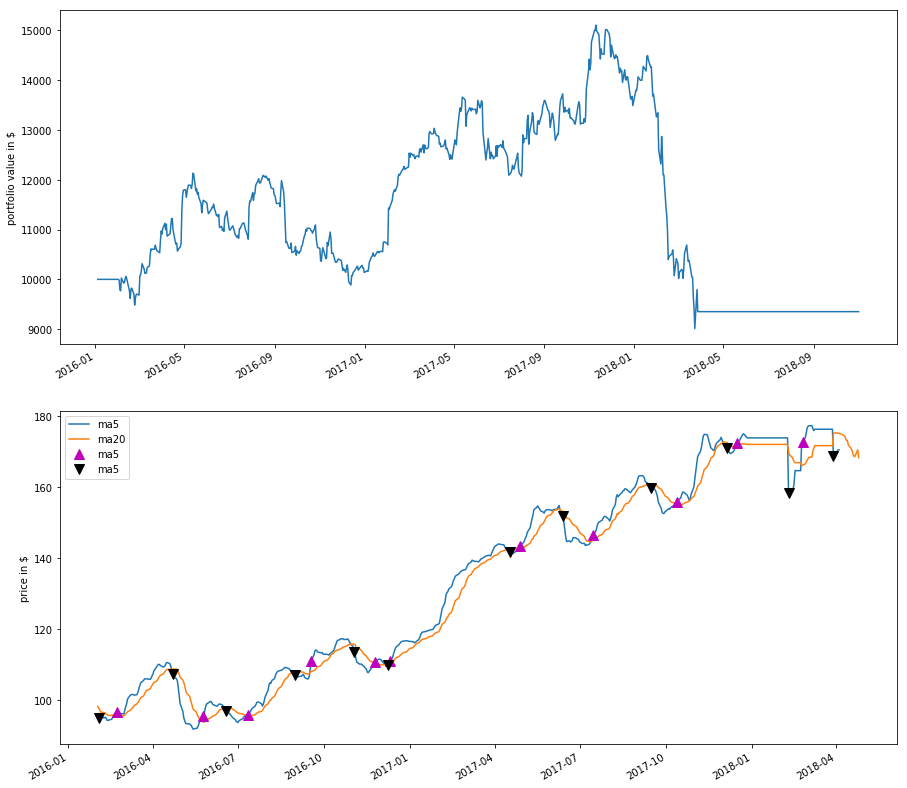

In [129]:
alg = zipline.run_algorithm(initialize=initialize, handle_data=handle_data, start=pd.to_datetime("2016-1-1").tz_localize('utc'), end=pd.to_datetime("2018-10-31").tz_localize('utc'), capital_base=capital, analyze=analyze)

In [132]:
alg

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,buy,capital_used,ending_cash,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2016-01-04 21:00:00+00:00,NaN,NaN,0.000000,NaN,-0.013983,NaN,NaN,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,1,[],0.0
2016-01-05 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.012312,0.175987,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,2,[],0.0
2016-01-06 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.024771,0.137848,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,3,[],0.0
2016-01-07 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.048168,0.167866,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,4,[],0.0
2016-01-08 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.058601,0.145652,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,5,[],0.0
2016-01-11 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.057684,0.154952,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,6,[],0.0
2016-01-12 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.050077,0.177553,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,7,[],0.0
2016-01-13 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.073773,0.192030,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,8,[],0.0
2016-01-14 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.058567,0.225895,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,9,[],0.0
2016-01-15 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.078776,0.225684,0.000000,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,10,[],0.0


In [133]:
alg.columns

Index(['AAPL', 'algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta', 'buy',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'ma20', 'ma5', 'max_drawdown', 'max_leverage',
       'net_leverage', 'orders', 'period_close', 'period_label', 'period_open',
       'pnl', 'portfolio_value', 'positions', 'returns', 'sell', 'sharpe',
       'short_exposure', 'short_value', 'shorts_count', 'sortino',
       'starting_cash', 'starting_exposure', 'starting_value', 'trading_days',
       'transactions', 'treasury_period_return'],
      dtype='object')

In [135]:
alg.portfolio_value

2016-01-04 21:00:00+00:00    10000.000000
2016-01-05 21:00:00+00:00    10000.000000
2016-01-06 21:00:00+00:00    10000.000000
2016-01-07 21:00:00+00:00    10000.000000
2016-01-08 21:00:00+00:00    10000.000000
2016-01-11 21:00:00+00:00    10000.000000
2016-01-12 21:00:00+00:00    10000.000000
2016-01-13 21:00:00+00:00    10000.000000
2016-01-14 21:00:00+00:00    10000.000000
2016-01-15 21:00:00+00:00    10000.000000
2016-01-19 21:00:00+00:00    10000.000000
2016-01-20 21:00:00+00:00    10000.000000
2016-01-21 21:00:00+00:00    10000.000000
2016-01-22 21:00:00+00:00    10000.000000
2016-01-25 21:00:00+00:00    10000.000000
2016-01-26 21:00:00+00:00    10000.000000
2016-01-27 21:00:00+00:00    10000.000000
2016-01-28 21:00:00+00:00    10000.000000
2016-01-29 21:00:00+00:00    10000.000000
2016-02-01 21:00:00+00:00    10000.000000
2016-02-02 21:00:00+00:00     9981.111086
2016-02-03 21:00:00+00:00     9794.111086
2016-02-04 21:00:00+00:00     9769.111086
2016-02-05 21:00:00+00:00    10027

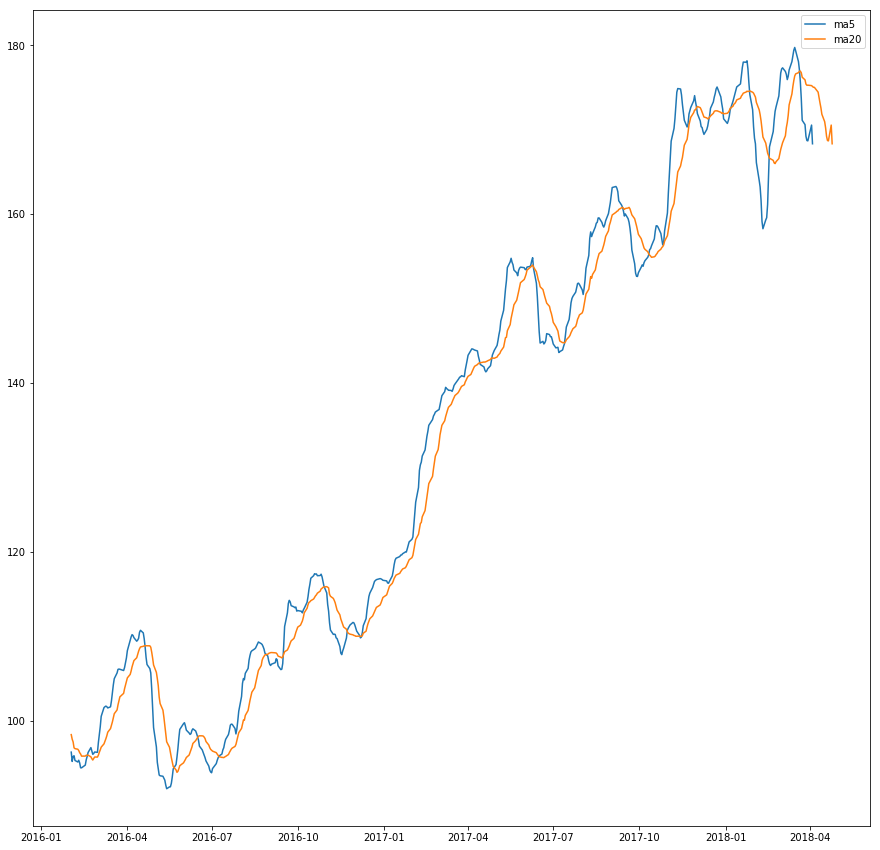

In [91]:
plt.figure(figsize=(15,15))

plt.plot(alg.index, alg.ma5)
plt.plot(alg.index, alg.ma20)
plt.legend(loc='best')

# plt.plot(alg.ix[alg.buy == True].index, alg.ma5[alg.buy == True], '^')
# plt.plot(alg.ix[alg.sell == True].index, alg.ma5[alg.sell == True], 'v')

plt.show()

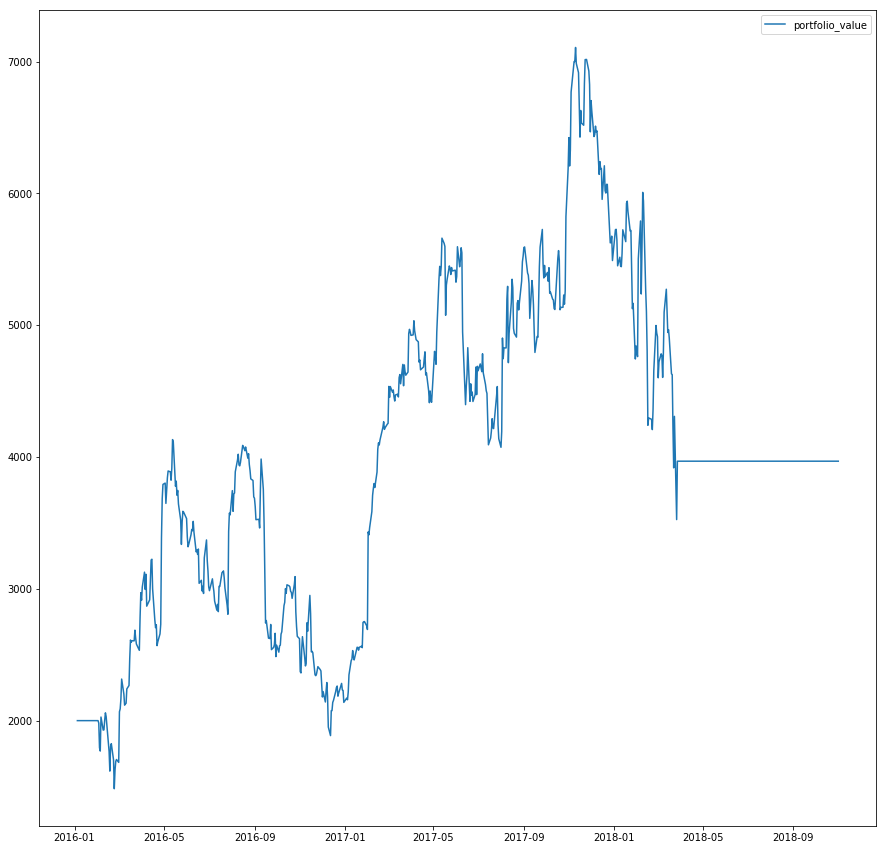

In [22]:
plt.figure(figsize=(15,15))
plt.plot(alg.index, alg.portfolio_value)
plt.legend(loc='best')
plt.show()

In [63]:
aapl = quandl.get("EOD/AAPL")

In [66]:
aapl = aapl.Adj_Close
aapl.columns = ['AAPL']

In [68]:
aapl.columns

['AAPL']